70.7182254419 True 204


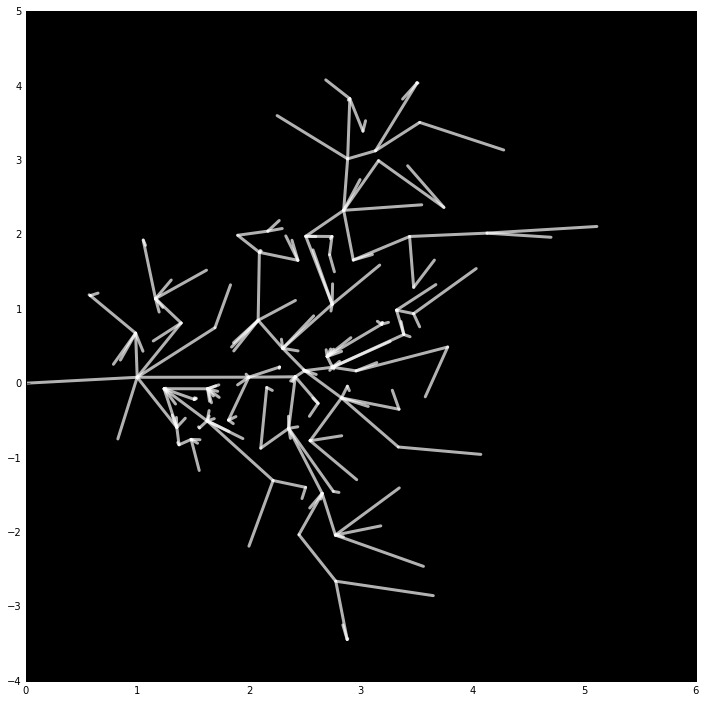

In [88]:
import numpy as np
import shapely.geometry as shg
import matplotlib.pyplot as plt
import copy as cp
import scipy.spatial.distance as scd

%matplotlib inline
plt.ion()

COLOR = {
    True:  'white',
    False: '#ffcc33'
    }

def v_color(ob):
    return COLOR[ob.is_simple]

def plot_tree(ax,ob):
    #for line in ob:
    #    x, y = line.xy
    #    ax.plot(x, y, 'o', color='#999999', zorder=1)
        
    #x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    #ax.plot(x, y, 'o', color='#000000', zorder=1)
    
    for line in ob:
        x, y = line.xy
        ax.plot(x, y, color=v_color(ob), alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

#no of interations
iterations = 300
max = 5
max_branch = 137.5
parent_id = 1
node_idx = 1
inter_pts = 7
prev_ang = 0
r = np.linspace(.99,.26,inter_pts)

min_dist = .1

bfactor = 1

#stack initial point

segments = []
segments_term = [np.array([0.,0])]

#expander node

expander = 1

#child to parent mapping

chp = {}

chp[1] = 0

#parent to child mapping

pch = {}

#node angle

pang = {}

pang[0] = 0

def get_segment(rot,r=1):
    start_pt = np.array([1., 0])
    R = r*np.array([
                    [ np.cos(rot*np.pi/180), -np.sin(rot*np.pi/180)],
                    [ np.sin(rot*np.pi/180), np.cos(rot*np.pi/180)]
                ])
    return np.dot(R,start_pt)

#flatten list

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

#get subtree

def get_subtree(par_to_ch,node_no):
    if node_no not in par_to_ch.keys():
        return node_no
    elif isinstance(par_to_ch[node_no],int):
        return [node_no] + [get_subtree(par_to_ch,par_to_ch[node_no])]
    else:
        return [node_no] + flatten([get_subtree(par_to_ch,node) for node in par_to_ch[node_no]])

def path_to_root(ch_to_par,node_no):
    if node_no not in ch_to_par.keys():
        return 1
    else:
        return [node_no] + flatten([path_to_root(ch_to_par,ch_to_par[node_no])])

#initialization of tree
# first segment

ang = (np.random.random()*(-2*max)+max) + prev_ang
new_segt = segments_term[expander-1], (segments_term[expander-1] + get_segment(ang))
test_line = shg.LineString(new_segt)
prev_ang = prev_ang + ang
segments.append( cp.copy(new_segt) )
segments_term.append(new_segt[1])

expander += 1

node_idx += 1

#update dicts

chp[expander] = expander - 1

pch[expander - 1] = (expander,)

#second segment

ang = (np.random.random()*(-2*max)+max) + prev_ang
new_segt = segments_term[expander-1], (segments_term[expander-1] + get_segment(ang))
test_line = shg.LineString(new_segt)
segments.append( cp.copy(new_segt) )
segments_term.append(new_segt[1])
delayed_tree = shg.MultiLineString(segments[:-1])

expander += 1

node_idx += 1

chp[expander] = expander - 1

pch[expander - 1] = (expander,)

for k in np.arange(iterations):
    
    parent_id = chp[expander]

    #build tree
    
    delayed_tree = shg.MultiLineString(segments[:-1])
    
    #set this just in case
    
    hammerTime = True
    counter = 0
    
    #add next segment
    #draw angle and length
    x = np.max(bfactor*np.random.random(),min_dist+.1)
    ang = (np.random.random()*(-2*max)+max) + prev_ang
    new_segt = segments_term[parent_id], (segments_term[parent_id] + get_segment(ang,x))
    
    #check if there is no intersection
    
    test_line = shg.LineString(new_segt)
    dist = delayed_tree.distance(test_line)
    
    #if no then add segment
    
    if dist > min_dist:
        prev_ang = ang
        segments.append( cp.copy(new_segt) )
        segments_term.append(cp.copy(new_segt[1]))
        #tree = shg.MultiLineString(segments)
        
        expander += 1
        node_idx += 1
        
        chp[expander] = expander - 1
        try:
            pch[expander - 1] = pch[expander - 1] + (expander,)
        except:
            pch[expander - 1] = (expander,)
    #else try another one
    else:
        counter = 0
        while counter < 10 and hammerTime:
            x = np.max(bfactor*np.random.random(),min_dist+.1)
            ang = (np.random.random()*(-2*max)+max) + prev_ang
            new_segt = segments_term[ parent_id ], (segments_term[ parent_id ] + get_segment(ang,x))
            test_line = shg.LineString(new_segt)
            dist = delayed_tree.distance(test_line)
            if dist > min_dist:
                prev_ang = ang
                segments.append( cp.copy(new_segt) )
                segments_term.append(cp.copy(new_segt[1]))
                #tree = shg.MultiLineString(segments)
                delayed_tree = shg.MultiLineString(segments[:-1])
                
                expander += 1
                node_idx += 1
                
                hammerTime = False
                
                chp[expander] = expander - 1
                
                try:
                    pch[expander - 1] = pch[expander - 1] + (expander,)
                except:
                    pch[expander - 1] = (expander,)  
                    
            counter += 1
    
    #################################################################
    # draw from existing nodes node to branch                       #
    #################################################################
    
    node = np.random.choice(np.arange(1,node_idx-1))
    #get all immediate neighbours of the node
    
    parent_id = chp[node]
    
    try:
        children = pch[node]
    except:
        children = []
        
    delayed_tree = shg.MultiLineString([segment for segment in segments if not (segment==segments_term[node]).any()  ])
    #draw new branch at the node
    counter = 0
    hammerTime = True
    
    while counter < 30 and hammerTime:
        x = np.max(bfactor*np.random.random(),min_dist+.1)
        ang = (np.random.random()*(-2*max_branch)+max_branch)
        new_segt = segments_term[ node ], (segments_term[ node ] + get_segment(ang,x))
        test_line = shg.LineString(new_segt)
        dist = delayed_tree.distance(test_line)
        if dist > min_dist:
            segments.append( cp.copy(new_segt) )
            segments_term.append(cp.copy(new_segt[1]))
            #tree = shg.MultiLineString(segments)
                
            node_idx += 1
                
            hammerTime = False
                
            chp[ node_idx ] = node
                
            try:
                pch[ node ] = pch[ node ] + (node_idx,)
            except:
                pch[ node ] = (node_idx,)  
                    
        counter += 1  
        


tree = shg.MultiLineString(segments)

print tree.length, tree.is_simple, len(segments)

#plot
fig = plt.figure(1,figsize=(12,12), dpi=300)

ax = fig.add_subplot(111,axisbg='black')
#plot_coords(ax, tree)
#plot_bounds(ax, tree)

plot_tree(ax, tree)
plt.draw()


In [ ]:
pc = {}
cp = {}

pc[0] = 1
pc[1] = 2
pc[2] = 3
pc[3] = (4,5,6)

pc[4] = (7,8)
pc[5] = (9,10)
pc[6] = 11
cp[1] = 0
cp[2] = 1
cp[3] = 2
cp[4] = 3
cp[5] = 3
cp[6] = 3
cp[7] = 4
cp[8] = 4
cp[9] = 5
cp[10] = 5
cp[11] = 6

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

#get subtree

def get_subtree(par_to_ch,node_no):
    if node_no not in par_to_ch.keys():
        return node_no
    elif isinstance(par_to_ch[node_no],int):
        return [node_no] + [get_subtree(par_to_ch,par_to_ch[node_no])]
    else:
        return [node_no] + flatten([get_subtree(par_to_ch,node) for node in par_to_ch[node_no]])

def path_to_root(ch_to_par,node_no):
    if node_no not in ch_to_par.keys():
        return 0
    else:
        return [node_no] + flatten([path_to_root(ch_to_par,ch_to_par[node_no])])
    
print path_to_root(cp,3)[1:]

print get_subtree(pc,3)[1:]

In [6]:
import numpy as np
import shapely.geometry as shg
import matplotlib.pyplot as plt
import copy as cp
import scipy.spatial.distance as scd


COLOR = {
    True:  'black',
    False: '#ffcc33'
    }

def v_color(ob):
    return COLOR[ob.is_simple]

def plot_tree(ax,ob):
    #for line in ob:
    #    x, y = line.xy
    #    ax.plot(x, y, 'o', color='#999999', zorder=1)
        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#000000', zorder=1)
    
    for line in ob:
        x, y = line.xy
        ax.plot(x, y, color=v_color(ob), alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
        

        
tree = shg.MultiLineString([((1,1),(2,2)),((0,0),(1,1)),((2,2),(1.5,2)),((-1,1),(-2,1.2)),((-2,1.2),(-2.3,6)),(3,3)])       
        
        
print tree.length, tree.is_simple

#plot

plot_tree(plt, tree)
plt.draw()      

a  = (1,2,3,4)
print a[:-1]

ValueError: Input (3, 3) is the wrong shape for a LineString